# Custom Angular Grid
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  01/05/2024          |
| Updated |  03/18/2024          |

## YFJ's Version ([`149454e`](https://github.com/yanfeij/athena_master/commit/149454ee76c5868288fcca6e478bfe5e7862c253))

In [1]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 1) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, polar_angle = True, diag = False):
    nang = 4*npsi*nzeta + 2

    coszeta_max = 1.0
    if polar_angle:
        coszeta_max = (float(nang) - 2)/float(nang)
    
    # // separate ghost zones and active zones
    # // so that they can be compatible with different angular scheme
    if (nzeta > 0):
        coszeta_v = np.empty(2*nzeta)
        coszeta_f = np.empty(2*nzeta+1)
        len_zeta = np.empty(2*nzeta) # // This id Delta (cos\theta)

    zs = 0 # ze = 2*nzeta - 1
    # Sum = 0
    dcoszeta = coszeta_max/nzeta
    coszeta_f[zs] = coszeta_max
    for i in range(1, nzeta, 1):
        coszeta_f[i+zs] = coszeta_max - i *dcoszeta
    
    coszeta_f[nzeta+zs] = 0.0
    for i in range(nzeta+1, 2*nzeta+1, 1):
        coszeta_f[i+zs] = -coszeta_f[2*nzeta-i+zs]
        
    for i in range(0, nzeta, 1):
        coszeta_v[i+zs] = 0.5*(coszeta_f[i+zs]+coszeta_f[i+zs+1])
        # Sum += np.power(coszeta_v[i+zs], 2)

    if diag:
        print(f'dcoszeta = {dcoszeta}')
        print(f'coszeta_f = {coszeta_f}')
        # print(f'coszeta_v = {coszeta_v}')

    # // re-normalize
    # Sum *= 2*npsi
    # normalization = np.sqrt((nang/3 - 2)/Sum)
    normalization = 2*nzeta/np.sqrt(4*nzeta*nzeta-1)

    # // need to change this later
    if not polar_angle:

        for i in range(0, nzeta, 1):
            coszeta_v[i+zs] *= normalization



    for i in range(nzeta, 2*nzeta, 1):
        coszeta_v[i+zs] = -coszeta_v[2*nzeta-i-1+zs]
      
    
    for i in range(0, nzeta*2, 1):
        len_zeta[i] = coszeta_f[i] - coszeta_f[i+1]

    if diag:
        # print(f'Sum = {Sum}')
        print(f'nang = {nang}')
        # print(f'normalization = {normalization}')

    return coszeta_v

In [2]:
npsi = 2
nzeta = 2
GetCoszeta_v(nzeta, npsi, diag = True)

dcoszeta = 0.4444444444444444
coszeta_f = [ 0.88888889  0.44444444  0.         -0.44444444 -0.88888889]
nang = 18


array([ 0.66666667,  0.22222222, -0.22222222, -0.66666667])

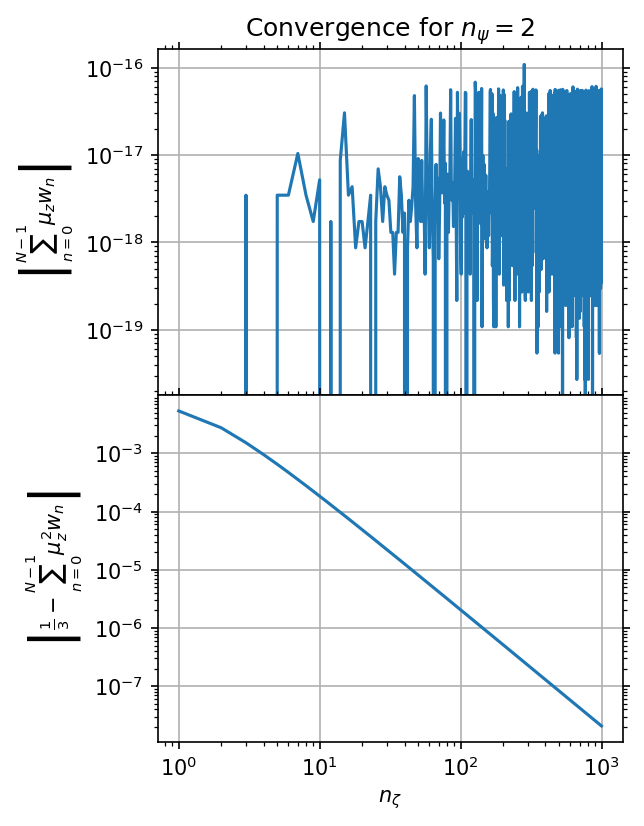

In [3]:
#===============================================================================
import matplotlib.pyplot as plt

diag = False

# Compute moment sums
npsi = 2
nzetas = range(1, 1000, 1)
mom1sums = np.zeros(len(nzetas))
mom2sums = np.zeros(len(nzetas))

for z,nzeta in enumerate(nzetas):
    nang = 2*npsi*2*nzeta + 2
    w = 1.0/nang
    mom1sum = 0
    mom2sum = 0
    mom1sum += 1.0*w -1.0*w # start with north and south poles
    mom2sum += 2*w
    coszeta_v = GetCoszeta_v(nzeta, npsi)

    for i in range(0, 2*npsi, 1):
        for j in range(0, 2*nzeta, 1):
            mom1sum += coszeta_v[j]*w
            mom2sum += coszeta_v[j]**2*w

    mom1sums[z] = mom1sum
    mom2sums[z] = mom2sum

    if diag:
        print(f'nang = {nang}')
        print(f'1st moment sum: {mom1sum}')
        print(f'2nd moment sum: {mom2sum}')

# Plot error vs. nzeta
fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)

axs[0].plot(nzetas, np.abs(mom1sums))
axs[1].plot(nzetas, np.abs(mom2sums - 1/3))

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log', xscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].set(title=f'Convergence for $n_\psi = {npsi}$',
           ylabel=r'$\left|\sum_{n=0}^{N-1}\mu_z w_n\right|$')
axs[1].set(xlabel=r'$n_\zeta$',
           ylabel=r'$\left|\frac{1}{3} - \sum_{n=0}^{N-1}\mu_z^2w_n\right|$')
plt.subplots_adjust(hspace=0.0)

## `angle_flag == 2`
### $n_\zeta$ excludes poles

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0 < \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$.
Note, these angles do not include the two default rays along the north and south poles, aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.

If $\zeta_1^\mathrm{f}$ defines the polar angle of the cell interface that bounds the solid angle subtended by the north pole, then
\begin{align*}
    \int \mathrm{d}\Omega &= \int_0^{2\pi}\mathrm{d}\psi\int_0^{\zeta_1^\mathrm{f}}\sin\zeta\mathrm{d}\zeta \\
    \Omega &= 2\pi\left(1 - \cos\zeta_1^\mathrm{f}\right).
    \tag{A}
\end{align*}
Meanwhile, the solid angle subtended by any mid-latitude ray (between the poles), where $0 < \zeta_i^\mathrm{f} < \pi$ defines the $n_\zeta + 1$ cell interfaces, is
\begin{equation*}
    \Omega = \frac{\pi}{n_\psi}\left(\cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}\right),
    \tag{B}
\end{equation*}
for $i \in \Bbb{N}$ and $1 \leq i < n_\zeta + 1$.
For $2n_\psi n_\zeta + 2$ equivalent solid angles subtended by unique cell-centered rays $\zeta_i^\mathrm{v}$ where 
\begin{equation*}
    \cos\zeta_i^\mathrm{v} = \frac{\cos\zeta_i^\mathrm{f} + \cos\zeta_{i+1}^\mathrm{f}}{2},
\tag{C}
\end{equation*}
we find
\begin{align*}
    (2n_\psi n_\zeta + 2)\Omega &= 2\pi\left(1 - \cos\zeta_1^\mathrm{f}\right) + 2n_\psi n_\zeta\frac{\pi}{n_\psi}\left(\cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}\right) + 2\pi\left(\cos\zeta_{i+1}^\mathrm{f} + 1\right) \\
    \Omega &= \frac{2\pi}{n_\psi n_\zeta + 1}.
    \tag{D}
\end{align*}
Combining equations (A) and (D) yields
\begin{equation*}
    \cos\zeta_1^\mathrm{f} = \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1}.
    \tag{E}
\end{equation*}
If $\Delta\cos\zeta \equiv \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}$, then combining equations (B) and (D) yields
\begin{equation*}
    \Delta\cos\zeta = \frac{2n_\psi}{n_\psi n_\zeta + 1}.
    \tag{F}
\end{equation*}
Thus,
\begin{equation*}
    \cos\zeta_{i+1}^\mathrm{f} = \cos\zeta_1^\mathrm{f} - i\Delta\cos\zeta.
    \tag{G}
\end{equation*}

In [4]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False, poles = True):
    coszeta_v = np.empty(nzeta+2)
    coszeta_f = np.empty(nzeta+3)
    Sum = 0

    coszeta_v[0] = coszeta_f[0] = 1.0              # north pole
    coszeta_v[nzeta+1] = coszeta_f[nzeta+2] = -1.0 # south pole

    coszeta_f[1] = npsi*nzeta/(npsi*nzeta + 1)
    dcoszeta = 2*npsi/(npsi*nzeta + 1)

    for i in range(1, nzeta+1, 1):
        coszeta_f[i+1] = coszeta_f[1] - i*dcoszeta
        coszeta_v[i] = (coszeta_f[i] + coszeta_f[i+1])/2
        Sum += np.power(coszeta_v[i], 2)

    if diag:
        print(f'dcoszeta = {dcoszeta}')
        print(f'coszeta_f = {coszeta_f}')
        # print(f'coszeta_v = {coszeta_v}')

    if nzeta > 1: # // re-normalize
        Sum *= 2*npsi
        nang = 2*npsi*nzeta + 2
        normalization = np.sqrt((nang/3 - 2)/Sum)

        for i in range(1, nzeta+1, 1):
            coszeta_v[i] *= normalization

        if diag:
            print(f'Sum = {Sum}')
            print(f'nang = {nang}')
            print(f'normalization = {normalization}')

    if not poles: # remove polar rays
        coszeta_v = np.delete(coszeta_v, 0)
        coszeta_v = np.delete(coszeta_v, -1)

    return coszeta_v

In [5]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False):
    coszeta_v = np.empty(2*nzeta)
    coszeta_f = np.empty(2*nzeta+1)

    zs = 0 # ze = 2*nzeta - 1
    Sum = 0
    dcoszeta = npsi/(npsi*nzeta + 1)
    coszeta_f[zs] = npsi*nzeta/(npsi*nzeta + 1)
    for i in range(0, 2*nzeta, 1):
        coszeta_f[i+zs+1] = coszeta_f[zs] - (i+1)*dcoszeta
        coszeta_v[i+zs] = 0.5*(coszeta_f[i+zs] + coszeta_f[i+zs+1])
        Sum += np.power(coszeta_v[i+zs], 2)

    if diag:
        print(f'dcoszeta = {dcoszeta}')
        print(f'coszeta_f = {coszeta_f}')
        # print(f'coszeta_v = {coszeta_v}')

    # re-normalize
    Sum *= 2*npsi
    nang = 2*npsi*2*nzeta + 2
    normalization = np.sqrt((nang/3 - 2)/Sum)

    # for i in range(0, 2*nzeta, 1):
        # coszeta_v[i+zs] *= normalization

    if diag:
        # print(f'Sum = {Sum}')
        print(f'nang = {nang}')
        # print(f'normalization = {normalization}')

    return coszeta_v

In [6]:
npsi = 2
nzeta = 2
GetCoszeta_v(nzeta, npsi, diag = True)

dcoszeta = 0.4
coszeta_f = [ 0.8  0.4  0.  -0.4 -0.8]
nang = 18


array([ 0.6,  0.2, -0.2, -0.6])

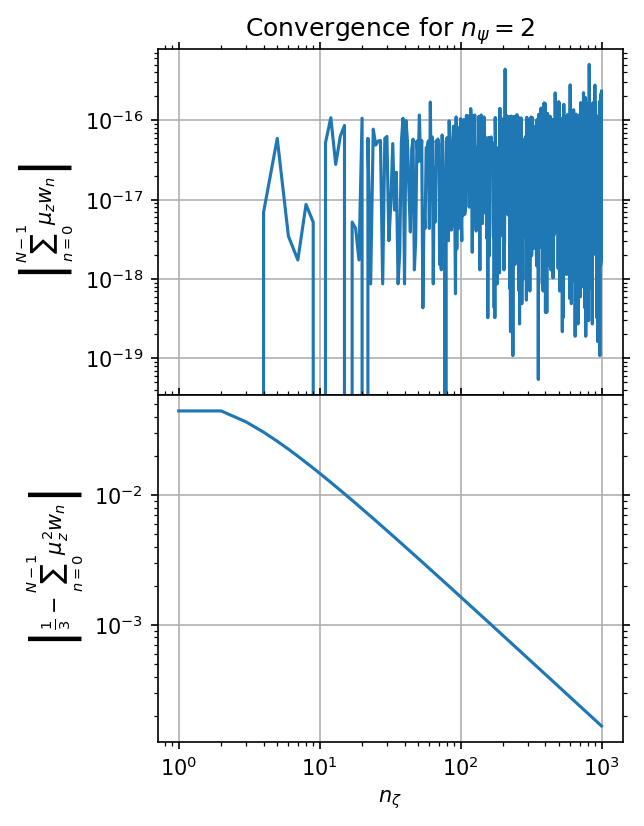

In [7]:
#===============================================================================
import matplotlib.pyplot as plt

diag = False

# Compute moment sums
npsi = 2
nzetas = range(1, 1000, 1)
mom1sums = np.zeros(len(nzetas))
mom2sums = np.zeros(len(nzetas))

for z,nzeta in enumerate(nzetas):
    nang = 2*npsi*2*nzeta + 2
    w = 1.0/nang
    mom1sum = 0
    mom2sum = 0
    mom1sum += 1.0*w -1.0*w # start with north and south poles
    mom2sum += 2*w
    coszeta_v = GetCoszeta_v(nzeta, npsi)

    for i in range(0, 2*npsi, 1):
        for j in range(0, 2*nzeta, 1):
            mom1sum += coszeta_v[j]*w
            mom2sum += coszeta_v[j]**2*w

    mom1sums[z] = mom1sum
    mom2sums[z] = mom2sum

    if diag:
        print(f'nang = {nang}')
        print(f'1st moment sum: {mom1sum}')
        print(f'2nd moment sum: {mom2sum}')

# Plot error vs. nzeta
fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)

axs[0].plot(nzetas, np.abs(mom1sums))
axs[1].plot(nzetas, np.abs(mom2sums - 1/3))

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log', xscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].set(title=f'Convergence for $n_\psi = {npsi}$',
           ylabel=r'$\left|\sum_{n=0}^{N-1}\mu_z w_n\right|$')
axs[1].set(xlabel=r'$n_\zeta$',
           ylabel=r'$\left|\frac{1}{3} - \sum_{n=0}^{N-1}\mu_z^2w_n\right|$')
plt.subplots_adjust(hspace=0.0)

### Re-normalization

To ensure eq. (11) of Jiang ([2021](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...49J/abstract)) is satisfied, we must solve for the renormalization factor $b$.
With $w_n = 1/N$, we find:
\begin{align*}
    \sum_{n=0}^{N-1} \mu_{n,\,z}^2w_n = 2w_n + \sum_{n=1}^{N-2} (b\cos\zeta_n^\mathrm{v})^2w_n &= \frac{1}{3} \\
    \sum_{n=0}^{N-1} (\cos\zeta_n^\mathrm{v})^2 &= \frac{N}{3b^2},
\end{align*}
where, from equations (C),
\begin{equation*}
    \cos\zeta_n^\mathrm{v} = \frac{\cos\zeta_n^\mathrm{f} + \cos\zeta_{n+1}^\mathrm{f}}{2}
\end{equation*}.
With $\cos\zeta_n^\mathrm{f} = 1 - n\Delta\cos\zeta$,
\begin{align*}
    \cos\zeta_n^\mathrm{v} &= \frac{1 - n\Delta\cos\zeta + 1 - (n + 1)\Delta\cos\zeta}{2} \\
\end{align*}

In [8]:
#===============================================================================
# https://docs.sympy.org/latest/modules/concrete.html#sympy.concrete.summations.summation
#===============================================================================
from sympy import summation, symbols

n, N = symbols('n N', integer=True)
D = symbols('(\Delta\cos\zeta)')

summation(D**2*(n**2 + n) - 2*D*n, (n, 0, N-1))

(\Delta\cos\zeta)**2*(N**3/3 - N**2/2 + N/6) + ((\Delta\cos\zeta)**2 - 2*(\Delta\cos\zeta))*(N**2/2 - N/2)

## `angle_flag == 1`

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0 < \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$.
Note, the north and south poles are aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.

For $n_\zeta$ unique cell-centered rays $\cos\zeta_i^\mathrm{v} = (\cos\zeta_{i}^\mathrm{f} + \cos\zeta_{i+1}^\mathrm{f})/2$, with $n_\zeta + 1$ cell interfaces $0 \leq \zeta_i^\mathrm{f} \leq \pi$, we have $n_\zeta$ equivalent solid angle $\Omega_i = \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}$ expressions related by
\begin{equation}
    \cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f} = \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} = ... = \cos\zeta_{n_\zeta - 1}^\mathrm{f} - \cos\zeta_{n_\zeta}^\mathrm{f}.
    \tag{A}
\end{equation}
The sum of $\Omega_i$ expressions implies
\begin{align*}
    n_\zeta\Omega &= \cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f} + \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} + ... + \cos\zeta_{n_\zeta - 1}^\mathrm{f} - \cos\zeta_{n_\zeta}^\mathrm{f} \\
    &= \cos\zeta_0^\mathrm{f} - \cos\zeta_{n_\zeta}^\mathrm{f}.
\end{align*}
As $\zeta_0^\mathrm{f} = 0$, and $\zeta_{n_\zeta}^\mathrm{f} = \pi$,
\begin{align*}
    n_\zeta\Omega &= 1 - (-1) \\
    \Delta\cos\zeta = \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f} \equiv \Omega &= \frac{2}{n_\zeta},
    \tag{B}
\end{align*}
Thus, the cell interfaces away from the first $\cos\zeta_0^\mathrm{f}$ at the north pole follow
\begin{equation*}
    \cos\zeta_{i}^\mathrm{f} = 1 - i\Delta\cos\zeta.
    \tag{C}
\end{equation*}


In [9]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   if (angle_flag == 1) {
import numpy as np

def GetCoszeta_v(nzeta = 2, diag = False):
    coszeta_v = np.empty(nzeta)
    coszeta_f = np.empty(nzeta+1)

    dcoszeta = 2.0/nzeta
    coszeta_f[0] = 1.0 # north pole

    for i in range(1, nzeta+1, 1):
        coszeta_f[i] = 1.0 - i*dcoszeta

    for i in range(0, nzeta, 1):
        coszeta_v[i] = (coszeta_f[i] + coszeta_f[i+1])/2

    # // re-normalize
    normalization = nzeta/np.sqrt(nzeta*nzeta - 1)

    for i in range(0, nzeta, 1):
        coszeta_v[i] *= normalization
    
    # Diagnostics
    if diag:
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v = {coszeta_v}')
    
    return coszeta_v 

In [10]:
nzeta = 16
GetCoszeta_v(nzeta, diag = True)

coszeta_f = [ 1.     0.875  0.75   0.625  0.5    0.375  0.25   0.125  0.    -0.125
 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875 -1.   ]
coszeta_v = [ 0.93933644  0.81409158  0.68884672  0.56360186  0.438357    0.31311215
  0.18786729  0.06262243 -0.06262243 -0.18786729 -0.31311215 -0.438357
 -0.56360186 -0.68884672 -0.81409158 -0.93933644]


array([ 0.93933644,  0.81409158,  0.68884672,  0.56360186,  0.438357  ,
        0.31311215,  0.18786729,  0.06262243, -0.06262243, -0.18786729,
       -0.31311215, -0.438357  , -0.56360186, -0.68884672, -0.81409158,
       -0.93933644])

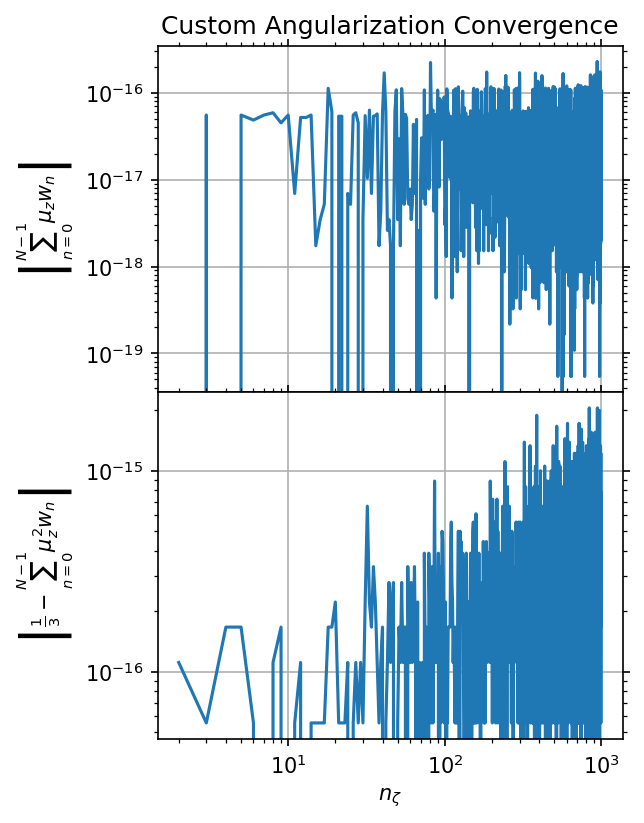

In [11]:
#===============================================================================
import matplotlib.pyplot as plt

# Compute moment sums
npsi = 2
nzetas = range(2, 1001, 1)
mom1sums = np.zeros(len(nzetas))
mom2sums = np.zeros(len(nzetas))

for z,nzeta in enumerate(nzetas):
    N = nzeta*2*npsi
    # print(f'N = {N}')
    w = 1.0/N
    mom1sum = 0
    mom2sum = 0
    coszeta_v = GetCoszeta_v(nzeta)

    for i in range(0, 2*npsi, 1):
        for j in range(0, nzeta, 1):
            mom1sum += coszeta_v[j]*w

    for i in range(0, 2*npsi, 1):
        for j in range(0, nzeta, 1):
            mom2sum += coszeta_v[j]**2*w

    mom1sums[z] = mom1sum
    mom2sums[z] = mom2sum
    # print(f'1st moment sum: {mom1sum}')
    # print(f'2nd moment sum: {mom2sum}')

# Plot error vs. nzeta
fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)

axs[0].plot(nzetas, np.abs(mom1sums))
axs[1].plot(nzetas, np.abs(mom2sums - 1/3))

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log', xscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].set(title='Custom Angularization Convergence',
           ylabel=r'$\left|\sum_{n=0}^{N-1}\mu_z w_n\right|$')
axs[1].set(xlabel=r'$n_\zeta$',
           ylabel=r'$\left|\frac{1}{3} - \sum_{n=0}^{N-1}\mu_z^2w_n\right|$')
plt.subplots_adjust(hspace=0.0)

## (old)

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0 < \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$, with $2n_\psi$ across the full $2\pi$.
Note, these do not include the two default rays along the north and south poles, aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.
Moreover, the equivalent solid angles $\Omega$ subtended by the rays along the north and south poles are
\begin{equation*}
    \Omega = 2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right),
    \tag{A}
\end{equation*}
where $0 \leq \zeta_i^\mathrm{f} \leq \pi$ defines the $n_\zeta + 3$ cell interfaces within a $\Delta\psi$.
For $n_\zeta$ unique cell-centered rays $\zeta_i^\mathrm{v}$, we have $n_\zeta + 2$ equivalent solid angle $\Omega$ expressions related by
\begin{equation*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} = ... = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right).
\end{equation*}
The sum of $\Omega$ expressions implies
\begin{equation*}
    (n_\zeta + 2)\Omega = 2n_\psi\cos\zeta_0^\mathrm{f} - 2n_\psi\cos\zeta_1^\mathrm{f} + \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} + ... + 2n_\psi\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi\cos\zeta_{n_\zeta + 2}^\mathrm{f}
\end{equation*}
As $\zeta_0^\mathrm{f} = 0$, and $\zeta_{n_\zeta + 2}^\mathrm{f} = \pi$,
\begin{align*}
    (n_\zeta + 2)\Omega &= 2n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi(-1) \\
    &= 4n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos(\pi - \zeta_1^\mathrm{f}) \\
    \Omega &= \frac{4n_\psi + (2 - 4n_\psi)\cos\zeta_1^\mathrm{f}}{n_\zeta + 2},
    \tag{B}
\end{align*}
where $0 < \zeta_1^\mathrm{f} < \pi/2$.

Combining equations (A) and (B) yields,
\begin{align*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) &= \frac{4n_\psi + (2 - 4n_\psi)\cos\zeta_1^\mathrm{f}}{n_\zeta + 2} \\
    2n_\psi n_\zeta - 2n_\psi n_\zeta\cos\zeta_1^\mathrm{f} + \xcancel{4n_\psi} - \xcancel{4n_\psi\cos\zeta_1^\mathrm{f}} &= \xcancel{4n_\psi} + 2\cos\zeta_1^\mathrm{f} - \xcancel{4n_\psi\cos\zeta_1^\mathrm{f}} \\
    \cos\zeta_1^\mathrm{f} = \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1}.
    \tag{C}
\end{align*}

Combining equations (B) and (C) yields,
\begin{align*}
    \Omega &= \frac{4n_\psi}{n_\zeta + 2} + \frac{(2 - 4n_\psi)n_\psi n_\zeta}{(n_\zeta + 2)(n_\psi n_\zeta + 1)} \\
    &= \frac{\xcancel{4n_\psi^2n_\zeta} + 4n_\psi + 2n_\psi n_\zeta - \xcancel{4n_\psi^2n_\zeta}}{(n_\zeta + 2)(n_\psi n_\zeta + 1)} \\
    \Omega &= \frac{2n_\psi}{n_\psi n_\zeta + 1}
    \tag{D}
\end{align*}

Using equation (D) for any given expression $\Omega_i$, where $1 \leq i < n_\zeta/2$ for odd $n_\zeta$ or $1 \leq i \leq n_\zeta/2$ for even $n_\zeta$,
\begin{align*}
    \frac{2in_\psi}{n_\psi n_\zeta + 1} &= \Omega_i \\
    &= \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f} \\
    &= \cos\zeta_1^\mathrm{f} - \cos\zeta_{i}^\mathrm{f} \\
    &= \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1} - \cos\zeta_{i}^\mathrm{f} \\
    \cos\zeta_{i}^\mathrm{f} &= \frac{n_\psi(n_\zeta - 2i)}{n_\psi n_\zeta + 1}.
    \tag*{QED}
\end{align*}

In [12]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False):
    coszeta_v = np.empty(nzeta+2)
    coszeta_f = np.empty(nzeta+3)

    coszeta_v[0] = coszeta_f[0] = 1.0              # north pole
    coszeta_v[nzeta+1] = coszeta_f[nzeta+2] = -1.0 # south pole
    
    fnzeta = float(nzeta)
    fnpsi = float(npsi)

    coszeta_f[1] = fnpsi*fnzeta/(fnpsi*fnzeta + 1)
    # dcoszeta = 2*npsi/(npsi*nzeta + 1)
    dcoszeta = (2 - 2*coszeta_f[1])/fnzeta

    for i in range(2, nzeta+2, 1):
        coszeta_f[i] = coszeta_f[1] - i*dcoszeta

    # if nzeta % 2 != 0: # odd nzeta
    #     for i in range(1, 2+nzeta//2, 1):
    #         coszeta_f[i] = coszeta_f[1] - i*dcoszeta
    #     for i in range(nzeta+1, 1+nzeta//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    # else:              # even nzeta
    #     for i in range(1, (nzeta+2)//2, 1):
    #         ccoszeta_f[i] = coszeta_f[1] - i*dcoszeta
    #     coszeta_f[(nzeta+2)//2] = 0
    #     for i in range(nzeta+1, (nzeta+2)//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]

    # if nzeta % 2 != 0: # odd nzeta
    #     for i in range(1, 2+nzeta//2, 1):
    #         coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1)
    #     for i in range(nzeta+1, 1+nzeta//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    # else:              # even nzeta
    #     for i in range(1, (nzeta+2)//2, 1):
    #         coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1)
    #     coszeta_f[(nzeta+2)//2] = 0
    #     for i in range(nzeta+1, (nzeta+2)//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    
    for i in range(1, nzeta + 1, 1):
        coszeta_v[i] = (coszeta_f[i] + coszeta_f[i+1])/2

    # // re-normalize
    # normalization = nzeta/np.sqrt(nzeta*nzeta - 1) # REDERIVE

    # for i in range(0, nzeta, 1):
    #     coszeta_v[i] *= normalization
    
    # Diagnostics
    if diag:
        print(f'dcoszeta = {dcoszeta}')
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v = {coszeta_v}')
    
    return coszeta_v 

### $n_\zeta$ includes poles

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0 < \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$, with $2n_\psi$ across the full $2\pi$.
Note, these do not include the two default rays along the north and south poles, aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.
Moreover, the equivalent solid angles $\Omega$ subtended by the rays along the north and south poles are
\begin{equation*}
    \Omega = 2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right),
    \tag{A}
\end{equation*}
where $0 \leq \zeta_i^\mathrm{f} \leq \pi$ defines the $n_\zeta + 3$ cell interfaces within a $\Delta\psi$.
For $n_\zeta$ unique cell-centered rays $\zeta_i^\mathrm{v}$, we have $n_\zeta + 2$ equivalent solid angle $\Omega$ expressions related by
\begin{equation*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} = ... = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right).
\end{equation*}
The sum of $\Omega$ expressions implies
\begin{equation*}
    (n_\zeta + 2)\Omega = 2n_\psi\cos\zeta_0^\mathrm{f} - 2n_\psi\cos\zeta_1^\mathrm{f} + \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} + ... + 2n_\psi\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi\cos\zeta_{n_\zeta + 2}^\mathrm{f}
\end{equation*}
As $\zeta_0^\mathrm{f} = 0$, and $\zeta_{n_\zeta + 2}^\mathrm{f} = \pi$,
\begin{align*}
    (n_\zeta + 2)\Omega &= 2n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi(-1) \\
    &= 4n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos(\pi - \zeta_1^\mathrm{f}) \\
    \Omega &= \frac{4n_\psi + (2 - 4n_\psi)\cos\zeta_1^\mathrm{f}}{n_\zeta + 2},
    \tag{B}
\end{align*}
where $0 < \zeta_1^\mathrm{f} < \pi/2$.

Combining equations (A) and (B) yields,
\begin{align*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) &= \frac{4n_\psi + (2 - 4n_\psi)\cos\zeta_1^\mathrm{f}}{n_\zeta + 2} \\
    2n_\psi n_\zeta - 2n_\psi n_\zeta\cos\zeta_1^\mathrm{f} + \xcancel{4n_\psi} - \xcancel{4n_\psi\cos\zeta_1^\mathrm{f}} &= \xcancel{4n_\psi} + 2\cos\zeta_1^\mathrm{f} - \xcancel{4n_\psi\cos\zeta_1^\mathrm{f}} \\
    \cos\zeta_1^\mathrm{f} = \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1}.
    \tag{C}
\end{align*}

Combining equations (B) and (C) yields,
\begin{align*}
    \Omega &= \frac{4n_\psi}{n_\zeta + 2} + \frac{(2 - 4n_\psi)n_\psi n_\zeta}{(n_\zeta + 2)(n_\psi n_\zeta + 1)} \\
    &= \frac{\xcancel{4n_\psi^2n_\zeta} + 4n_\psi + 2n_\psi n_\zeta - \xcancel{4n_\psi^2n_\zeta}}{(n_\zeta + 2)(n_\psi n_\zeta + 1)} \\
    \Omega &= \frac{2n_\psi}{n_\psi n_\zeta + 1}
    \tag{D}
\end{align*}

Using equation (D) for any given expression $\Omega_i$, where $1 \leq i < n_\zeta/2$ for odd $n_\zeta$ or $1 \leq i \leq n_\zeta/2$ for even $n_\zeta$,
\begin{align*}
    \frac{2in_\psi}{n_\psi n_\zeta + 1} &= \Omega_i \\
    &= \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f} \\
    &= \cos\zeta_1^\mathrm{f} - \cos\zeta_{i}^\mathrm{f} \\
    &= \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1} - \cos\zeta_{i}^\mathrm{f} \\
    \cos\zeta_{i}^\mathrm{f} &= \frac{n_\psi(n_\zeta - 2i)}{n_\psi n_\zeta + 1}.
    \tag*{QED}
\end{align*}

In [13]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False):
    coszeta_v = np.empty(nzeta)
    coszeta_f = np.empty(nzeta+1)

    coszeta_v[0] = coszeta_f[0] = 1.0            # north pole
    coszeta_v[nzeta-1] = coszeta_f[nzeta] = -1.0 # south pole
    
    dcoszeta = (8*npsi**2*nzeta**2 - 24*npsi**2*nzeta + 16*npsi**2\
                + 12*npsi*nzeta - 8*npsi)/(2*npsi*nzeta**3 - 4*npsi*nzeta**2\
                + 2*nzeta**2)
    coszeta_f[1] = (2*npsi*nzeta - 4*npsi)/(2*npsi*nzeta - 4*npsi + 2)

    if nzeta % 2 != 0: # odd nzeta
        for i in range(1, 1+nzeta//2, 1):
            coszeta_f[i] = coszeta_f[1] - i*dcoszeta
        for i in range(nzeta-1, nzeta//2, -1):
            coszeta_f[i] = -coszeta_f[nzeta-i]
    else:              # even nzeta
        for i in range(1, (nzeta+2)//2, 1):
            ccoszeta_f[i] = coszeta_f[1] - i*dcoszeta
        coszeta_f[(nzeta+2)//2] = 0
        for i in range(nzeta+1, (nzeta+2)//2, -1):
            coszeta_f[i] = -coszeta_f[nzeta+2-i]

    # if nzeta % 2 != 0: # odd nzeta
    #     for i in range(1, 2+nzeta//2, 1):
    #         coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1)
    #     for i in range(nzeta+1, 1+nzeta//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    # else:              # even nzeta
    #     for i in range(1, (nzeta+2)//2, 1):
    #         coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1)
    #     coszeta_f[(nzeta+2)//2] = 0
    #     for i in range(nzeta+1, (nzeta+2)//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    
    for i in range(1, nzeta-1, 1):
        coszeta_v[i] = (coszeta_f[i] + coszeta_f[i+1])/2

    # // re-normalize
    # normalization = nzeta/np.sqrt(nzeta*nzeta - 1) # REDERIVE

    # for i in range(0, nzeta, 1):
    #     coszeta_v[i] *= normalization
    
    # Diagnostics
    if diag:
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v = {coszeta_v}')
    
    return coszeta_v 

In [14]:
npsi = 2
nzeta = 5
GetCoszeta_v(nzeta, npsi, diag = True)

coszeta_f = [ 1.         -0.53714286 -3.32571429  3.32571429  0.53714286 -1.        ]
coszeta_v = [ 1.         -1.93142857  0.          1.93142857 -1.        ]


array([ 1.        , -1.93142857,  0.        ,  1.93142857, -1.        ])

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0 < \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$, with $2n_\psi$ across the full $2\pi$.
Note, these do not include the two default rays along the north and south poles, aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.
Moreover, the equivalent solid angles $\Omega$ subtended by the rays along the north and south poles are
\begin{equation*}
    \Omega = 2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right),
    \tag{A}
\end{equation*}
where $0 \leq \zeta_i^\mathrm{f} \leq \pi$ defines the $n_\zeta + 3$ cell interfaces within a $\Delta\psi$.
For $n_\zeta$ unique cell-centered rays $\zeta_i^\mathrm{v}$, we have $n_\zeta + 2$ equivalent solid angle $\Omega$ expressions related by
\begin{equation*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} = ... = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right).
\end{equation*}
The sum of $\Omega$ expressions implies
\begin{equation*}
    (n_\zeta + 2)\Omega = 2n_\psi\cos\zeta_0^\mathrm{f} - 2n_\psi\cos\zeta_1^\mathrm{f} + \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} + ... + 2n_\psi\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi\cos\zeta_{n_\zeta + 2}^\mathrm{f}
\end{equation*}
As $\zeta_0^\mathrm{f} = 0$, and $\zeta_{n_\zeta + 2}^\mathrm{f} = \pi$,
\begin{align*}
    (n_\zeta + 2)\Omega &= 2n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi(-1) \\
    &= 4n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos(\pi - \zeta_1^\mathrm{f}) \\
    \Omega &= \frac{4n_\psi + (2 - 4n_\psi)\cos\zeta_1^\mathrm{f}}{n_\zeta + 2},
    \tag{B}
\end{align*}
where $0 < \zeta_1^\mathrm{f} < \pi/2$.

Combining equations (A) and (B) yields,
\begin{align*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) &= \frac{4n_\psi + (2 - 4n_\psi)\cos\zeta_1^\mathrm{f}}{n_\zeta + 2} \\
    2n_\psi n_\zeta - 2n_\psi n_\zeta\cos\zeta_1^\mathrm{f} + \xcancel{4n_\psi} - \xcancel{4n_\psi\cos\zeta_1^\mathrm{f}} &= \xcancel{4n_\psi} + 2\cos\zeta_1^\mathrm{f} - \xcancel{4n_\psi\cos\zeta_1^\mathrm{f}} \\
    \cos\zeta_1^\mathrm{f} = \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1}.
    \tag{C}
\end{align*}

Combining equations (B) and (C) yields,
\begin{align*}
    \Omega &= \frac{4n_\psi}{n_\zeta + 2} + \frac{(2 - 4n_\psi)n_\psi n_\zeta}{(n_\zeta + 2)(n_\psi n_\zeta + 1)} \\
    &= \frac{\xcancel{4n_\psi^2n_\zeta} + 4n_\psi + 2n_\psi n_\zeta - \xcancel{4n_\psi^2n_\zeta}}{(n_\zeta + 2)(n_\psi n_\zeta + 1)} \\
    \Omega &= \frac{2n_\psi}{n_\psi n_\zeta + 1}
    \tag{D}
\end{align*}

Using equation (D) for any given expression $\Omega_i$, where $1 \leq i < n_\zeta/2$ for odd $n_\zeta$ or $1 \leq i \leq n_\zeta/2$ for even $n_\zeta$,
\begin{align*}
    \frac{2in_\psi}{n_\psi n_\zeta + 1} &= \Omega_i \\
    &= \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f} \\
    &= \cos\zeta_1^\mathrm{f} - \cos\zeta_{i}^\mathrm{f} \\
    &= \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1} - \cos\zeta_{i}^\mathrm{f} \\
    \cos\zeta_{i}^\mathrm{f} &= \frac{n_\psi(n_\zeta - 2i)}{n_\psi n_\zeta + 1}.
    \tag*{QED}
\end{align*}

In [15]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False):
    coszeta_v = np.empty(nzeta)
    coszeta_f = np.empty(nzeta+1)

    coszeta_v[0] = coszeta_f[0] = 1.0            # north pole
    coszeta_v[nzeta-1] = coszeta_f[nzeta] = -1.0 # south pole
    
    dcoszeta = (8*npsi**2*nzeta**2 - 24*npsi**2*nzeta + 16*npsi**2\
                + 12*npsi*nzeta - 8*npsi)/(2*npsi*nzeta**3 - 4*npsi*nzeta**2\
                + 2*nzeta**2)
    coszeta_f[1] = (2*npsi*nzeta - 4*npsi)/(2*npsi*nzeta - 4*npsi + 2)

    if nzeta % 2 != 0: # odd nzeta
        for i in range(1, 1+nzeta//2, 1):
            coszeta_f[i] = coszeta_f[1] - i*dcoszeta
        for i in range(nzeta-1, nzeta//2, -1):
            coszeta_f[i] = -coszeta_f[nzeta-i]
    else:              # even nzeta
        for i in range(1, (nzeta+2)//2, 1):
            ccoszeta_f[i] = coszeta_f[1] - i*dcoszeta
        coszeta_f[(nzeta+2)//2] = 0
        for i in range(nzeta+1, (nzeta+2)//2, -1):
            coszeta_f[i] = -coszeta_f[nzeta+2-i]

    # if nzeta % 2 != 0: # odd nzeta
    #     for i in range(1, 2+nzeta//2, 1):
    #         coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1)
    #     for i in range(nzeta+1, 1+nzeta//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    # else:              # even nzeta
    #     for i in range(1, (nzeta+2)//2, 1):
    #         coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1)
    #     coszeta_f[(nzeta+2)//2] = 0
    #     for i in range(nzeta+1, (nzeta+2)//2, -1):
    #         coszeta_f[i] = -coszeta_f[nzeta+2-i]
    
    for i in range(1, nzeta-1, 1):
        coszeta_v[i] = (coszeta_f[i] + coszeta_f[i+1])/2

    # // re-normalize
    # normalization = nzeta/np.sqrt(nzeta*nzeta - 1) # REDERIVE

    # for i in range(0, nzeta, 1):
    #     coszeta_v[i] *= normalization
    
    # Diagnostics
    if diag:
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v = {coszeta_v}')
    
    return coszeta_v 

In [16]:
npsi = 2
nzeta = 5
GetCoszeta_v(nzeta, npsi, diag = True)

coszeta_f = [ 1.         -0.53714286 -3.32571429  3.32571429  0.53714286 -1.        ]
coszeta_v = [ 1.         -1.93142857  0.          1.93142857 -1.        ]


array([ 1.        , -1.93142857,  0.        ,  1.93142857, -1.        ])

### Rederive $n_\zeta$ excluding poles without trigonometric identity (B)

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0  \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$, with $2n_\psi$ across the full $2\pi$.
Note, these do not include the two default rays along the north and south poles, aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.
Moreover, the equivalent solid angles $\Omega$ subtended by the rays along the north and south poles are
\begin{equation*}
    \Omega = 2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right),
    \tag{A}
\end{equation*}
where $0 \leq \zeta_i^\mathrm{f} \leq \pi$ defines the $n_\zeta + 3$ cell interfaces within a $\Delta\psi$.
For $n_\zeta$ unique cell-centered rays $\zeta_i^\mathrm{v}$, we have $n_\zeta + 2$ equivalent solid angle $\Omega$ expressions related by
\begin{equation*}
    2n_\psi\left(\cos\zeta_0^\mathrm{f} - \cos\zeta_1^\mathrm{f}\right) = \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} = ... = 2n_\psi\left(\cos\zeta_{n_\zeta + 1}^\mathrm{f} - \cos\zeta_{n_\zeta + 2}^\mathrm{f}\right).
\end{equation*}
The sum of $\Omega$ expressions implies
\begin{equation*}
    (n_\zeta + 2)\Omega = 2n_\psi\cos\zeta_0^\mathrm{f} - 2n_\psi\cos\zeta_1^\mathrm{f} + \cos\zeta_1^\mathrm{f} - \cos\zeta_2^\mathrm{f} + ... + 2n_\psi\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi\cos\zeta_{n_\zeta + 2}^\mathrm{f}
\end{equation*}
As $\zeta_0^\mathrm{f} = 0$, and $\zeta_{n_\zeta + 2}^\mathrm{f} = \pi$,
\begin{align*}
    (n_\zeta + 2)\Omega &= 2n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos\zeta_{n_\zeta + 1}^\mathrm{f} - 2n_\psi(-1) \\
    \Omega &= \frac{4n_\psi + (1 - 2n_\psi)\cos\zeta_1^\mathrm{f} + (2n_\psi - 1)\cos\zeta_{n_\zeta + 1}^\mathrm{f}}{n_\zeta + 2}.
    \tag{B}
\end{align*}

Combining equations (A) and (B) yields,
...

In [17]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False):
    coszeta_v = np.empty(nzeta+2)
    coszeta_f = np.empty(nzeta+3)

    # dcoszeta = npsi*(nzeta - 2) # CHECK IF NO LONGER NEEDED
    coszeta_v[0] = coszeta_f[0] = 1.0              # north pole
    coszeta_v[nzeta+1] = coszeta_f[nzeta+2] = -1.0 # south pole

    for i in range(1, nzeta + 2, 1):
        coszeta_f[i] = npsi*(nzeta - 2*i)/(npsi*nzeta + 1) # REVISE W/O TRIG ID

    for i in range(1, nzeta + 1, 1):
        coszeta_v[i] = (coszeta_f[i] + coszeta_f[i+1])/2

    # // re-normalize
    # normalization = nzeta/np.sqrt(nzeta*nzeta - 1) # REFIGURE OUT!!!

    # for i in range(0, nzeta, 1):
    #     coszeta_v[i] *= normalization
    
    # Diagnostics
    if diag:
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v = {coszeta_v}')
    
    return coszeta_v 

In [18]:
npsi = 2
nzeta = 1
GetCoszeta_v(diag = True)

coszeta_f = [ 1.         -0.66666667 -2.         -1.        ]
coszeta_v = [ 1.         -1.33333333 -1.        ]


array([ 1.        , -1.33333333, -1.        ])

## Visualization

In [19]:
import numpy as np

def FirstMomSum(ns):
    sums = np.empty(3)

    for i in range(ns[0].size - 1):
        sums[i] = np.sum(ns[:, i]*ns[:, 3]) # \Sum mu_x*w_n

    return sums

def SecondMomSum(ns):
    sums = np.empty(3)

    for i in range(ns[0].size - 1):
        sums[i] = np.sum(ns[:, i]**2*ns[:, 3]) # \Sum mu_x*w_n

    return sums

In [20]:
# From Rad_angles.txt with nzeta = 1 and npsi = 2
arr = [[ 5.773503e-01,  5.773503e-01,  5.773503e-01, 1.250000e-01],
       [ 5.773503e-01, -5.773503e-01,  5.773503e-01, 1.250000e-01],
       [ 5.773503e-01, -5.773503e-01, -5.773503e-01, 1.250000e-01],
       [ 5.773503e-01,  5.773503e-01, -5.773503e-01, 1.250000e-01],
       [-5.773503e-01,  5.773503e-01,  5.773503e-01, 1.250000e-01],
       [-5.773503e-01, -5.773503e-01,  5.773503e-01, 1.250000e-01],
       [-5.773503e-01, -5.773503e-01, -5.773503e-01, 1.250000e-01],
       [-5.773503e-01,  5.773503e-01, -5.773503e-01, 1.250000e-01]]
ns = np.asarray(arr)
print(f' First moment sum: {FirstMomSum(ns)}')
print(f'Second moment sum: {SecondMomSum(ns)}')

 First moment sum: [0. 0. 0.]
Second moment sum: [0.33333337 0.33333337 0.33333337]


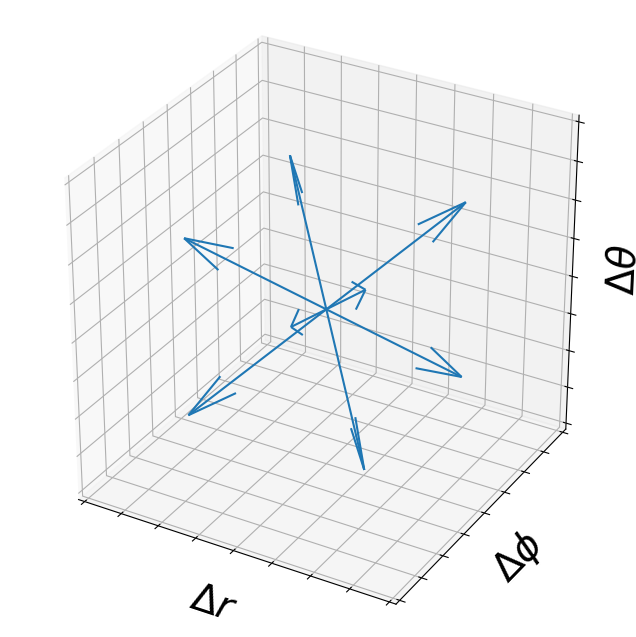

In [21]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

# Make the grid
mu_x, mu_y, mu_z = ns[:, 0], ns[:, 1], ns[:, 2]
x = np.zeros(mu_x.size)
y = np.zeros(mu_y.size)
z = np.zeros(mu_z.size)

ax.quiver(x, y, z, mu_x, mu_y, mu_z, length=1.0)
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), aspect='equal',
       xticklabels=[], yticklabels=[], zticklabels=[])
ax.set_xlabel(r'$\Delta r$', fontsize='28')
ax.set_ylabel(r'$\Delta \phi$', fontsize='28')
ax.set_zlabel(r'$\Delta \theta$', fontsize='28')
plt.savefig(f'figs/default.png', dpi=600, bbox_inches='tight', transparent=True,
            pad_inches=0.5)

In [22]:
# From Rad_angles.txt with nzeta = 8 and npsi = 2
arr = [[ 9.393364e-01 ,  2.425356e-01  , 2.425356e-01   , 1.562500e-02],
       [ 9.393364e-01 ,  -2.425356e-01 ,  2.425356e-01  ,  1.562500e-02],
       [ 9.393364e-01 ,  -2.425356e-01 ,  -2.425356e-01 ,   1.562500e-02],
       [ 9.393364e-01 ,  2.425356e-01  , -2.425356e-01  ,  1.562500e-02],
       [ 8.140916e-01 ,  4.106427e-01  , 4.106427e-01   , 1.562500e-02],
       [ 8.140916e-01 ,  -4.106427e-01 ,  4.106427e-01  ,  1.562500e-02],
       [ 8.140916e-01 ,  -4.106427e-01 ,  -4.106427e-01 ,   1.562500e-02],
       [ 8.140916e-01 ,  4.106427e-01  , -4.106427e-01  ,  1.562500e-02],
       [ 6.888467e-01 ,  5.125867e-01  , 5.125867e-01   , 1.562500e-02],
       [ 6.888467e-01 ,  -5.125867e-01 ,  5.125867e-01  ,  1.562500e-02],
       [ 6.888467e-01 ,  -5.125867e-01 ,  -5.125867e-01 ,   1.562500e-02],
       [ 6.888467e-01 ,  5.125867e-01  , -5.125867e-01  ,  1.562500e-02],
       [ 5.636019e-01 ,  5.841031e-01  , 5.841031e-01   , 1.562500e-02],
       [ 5.636019e-01 ,  -5.841031e-01 ,  5.841031e-01  ,  1.562500e-02],
       [ 5.636019e-01 ,  -5.841031e-01 ,  -5.841031e-01 ,   1.562500e-02],
       [ 5.636019e-01 ,  5.841031e-01  , -5.841031e-01  ,  1.562500e-02],
       [ 4.383570e-01 ,  6.355482e-01  , 6.355482e-01   , 1.562500e-02],
       [ 4.383570e-01 ,  -6.355482e-01 ,  6.355482e-01  ,  1.562500e-02],
       [ 4.383570e-01 ,  -6.355482e-01 ,  -6.355482e-01 ,   1.562500e-02],
       [ 4.383570e-01 ,  6.355482e-01  , -6.355482e-01  ,  1.562500e-02],
       [ 3.131121e-01 ,  6.715507e-01  , 6.715507e-01   , 1.562500e-02],
       [ 3.131121e-01 ,  -6.715507e-01 ,  6.715507e-01  ,  1.562500e-02],
       [ 3.131121e-01 ,  -6.715507e-01 ,  -6.715507e-01 ,   1.562500e-02],
       [ 3.131121e-01 ,  6.715507e-01  , -6.715507e-01  ,  1.562500e-02],
       [ 1.878673e-01 ,  6.945163e-01  , 6.945163e-01   , 1.562500e-02],
       [ 1.878673e-01 ,  -6.945163e-01 ,  6.945163e-01  ,  1.562500e-02],
       [ 1.878673e-01 ,  -6.945163e-01 ,  -6.945163e-01 ,   1.562500e-02],
       [ 1.878673e-01 ,  6.945163e-01  , -6.945163e-01  ,  1.562500e-02],
       [ 6.262243e-02 ,  7.057189e-01  , 7.057189e-01   , 1.562500e-02],
       [ 6.262243e-02 ,  -7.057189e-01 ,  7.057189e-01  ,  1.562500e-02],
       [ 6.262243e-02 ,  -7.057189e-01 ,  -7.057189e-01 ,   1.562500e-02],
       [ 6.262243e-02 ,  7.057189e-01  , -7.057189e-01  ,  1.562500e-02],
       [ -6.262243e-02,   7.057189e-01 ,  7.057189e-01  ,  1.562500e-02],
       [ -6.262243e-02,   -7.057189e-01,   7.057189e-01 ,   1.562500e-02],
       [ -6.262243e-02,   -7.057189e-01,   -7.057189e-01,    1.562500e-02],
       [ -6.262243e-02,   7.057189e-01 ,  -7.057189e-01 ,   1.562500e-02],
       [ -1.878673e-01,   6.945163e-01 ,  6.945163e-01  ,  1.562500e-02],
       [ -1.878673e-01,   -6.945163e-01,   6.945163e-01 ,   1.562500e-02],
       [ -1.878673e-01,   -6.945163e-01,   -6.945163e-01,    1.562500e-02],
       [ -1.878673e-01,   6.945163e-01 ,  -6.945163e-01 ,   1.562500e-02],
       [ -3.131121e-01,   6.715507e-01 ,  6.715507e-01  ,  1.562500e-02],
       [ -3.131121e-01,   -6.715507e-01,   6.715507e-01 ,   1.562500e-02],
       [ -3.131121e-01,   -6.715507e-01,   -6.715507e-01,    1.562500e-02],
       [ -3.131121e-01,   6.715507e-01 ,  -6.715507e-01 ,   1.562500e-02],
       [ -4.383570e-01,   6.355482e-01 ,  6.355482e-01  ,  1.562500e-02],
       [ -4.383570e-01,   -6.355482e-01,   6.355482e-01 ,   1.562500e-02],
       [ -4.383570e-01,   -6.355482e-01,   -6.355482e-01,    1.562500e-02],
       [ -4.383570e-01,   6.355482e-01 ,  -6.355482e-01 ,   1.562500e-02],
       [ -5.636019e-01,   5.841031e-01 ,  5.841031e-01  ,  1.562500e-02],
       [ -5.636019e-01,   -5.841031e-01,   5.841031e-01 ,   1.562500e-02],
       [ -5.636019e-01,   -5.841031e-01,   -5.841031e-01,    1.562500e-02],
       [ -5.636019e-01,   5.841031e-01 ,  -5.841031e-01 ,   1.562500e-02],
       [ -6.888467e-01,   5.125867e-01 ,  5.125867e-01  ,  1.562500e-02],
       [ -6.888467e-01,   -5.125867e-01,   5.125867e-01 ,   1.562500e-02],
       [ -6.888467e-01,   -5.125867e-01,   -5.125867e-01,    1.562500e-02],
       [ -6.888467e-01,   5.125867e-01 ,  -5.125867e-01 ,   1.562500e-02],
       [ -8.140916e-01,   4.106427e-01 ,  4.106427e-01  ,  1.562500e-02],
       [ -8.140916e-01,   -4.106427e-01,   4.106427e-01 ,   1.562500e-02],
       [ -8.140916e-01,   -4.106427e-01,   -4.106427e-01,    1.562500e-02],
       [ -8.140916e-01,   4.106427e-01 ,  -4.106427e-01 ,   1.562500e-02],
       [ -9.393364e-01,   2.425356e-01 ,  2.425356e-01  ,  1.562500e-02],
       [ -9.393364e-01,   -2.425356e-01,   2.425356e-01 ,   1.562500e-02],
       [ -9.393364e-01,   -2.425356e-01,   -2.425356e-01,    1.562500e-02],
       [ -9.393364e-01,   2.425356e-01,   -2.425356e-01,    1.562500e-02]]
ns = np.asarray(arr)
print(f' First moment sum: {FirstMomSum(ns)}')
print(f'Second moment sum: {SecondMomSum(ns)}')

 First moment sum: [2.77555756e-17 0.00000000e+00 0.00000000e+00]
Second moment sum: [0.33333333 0.3333333  0.3333333 ]


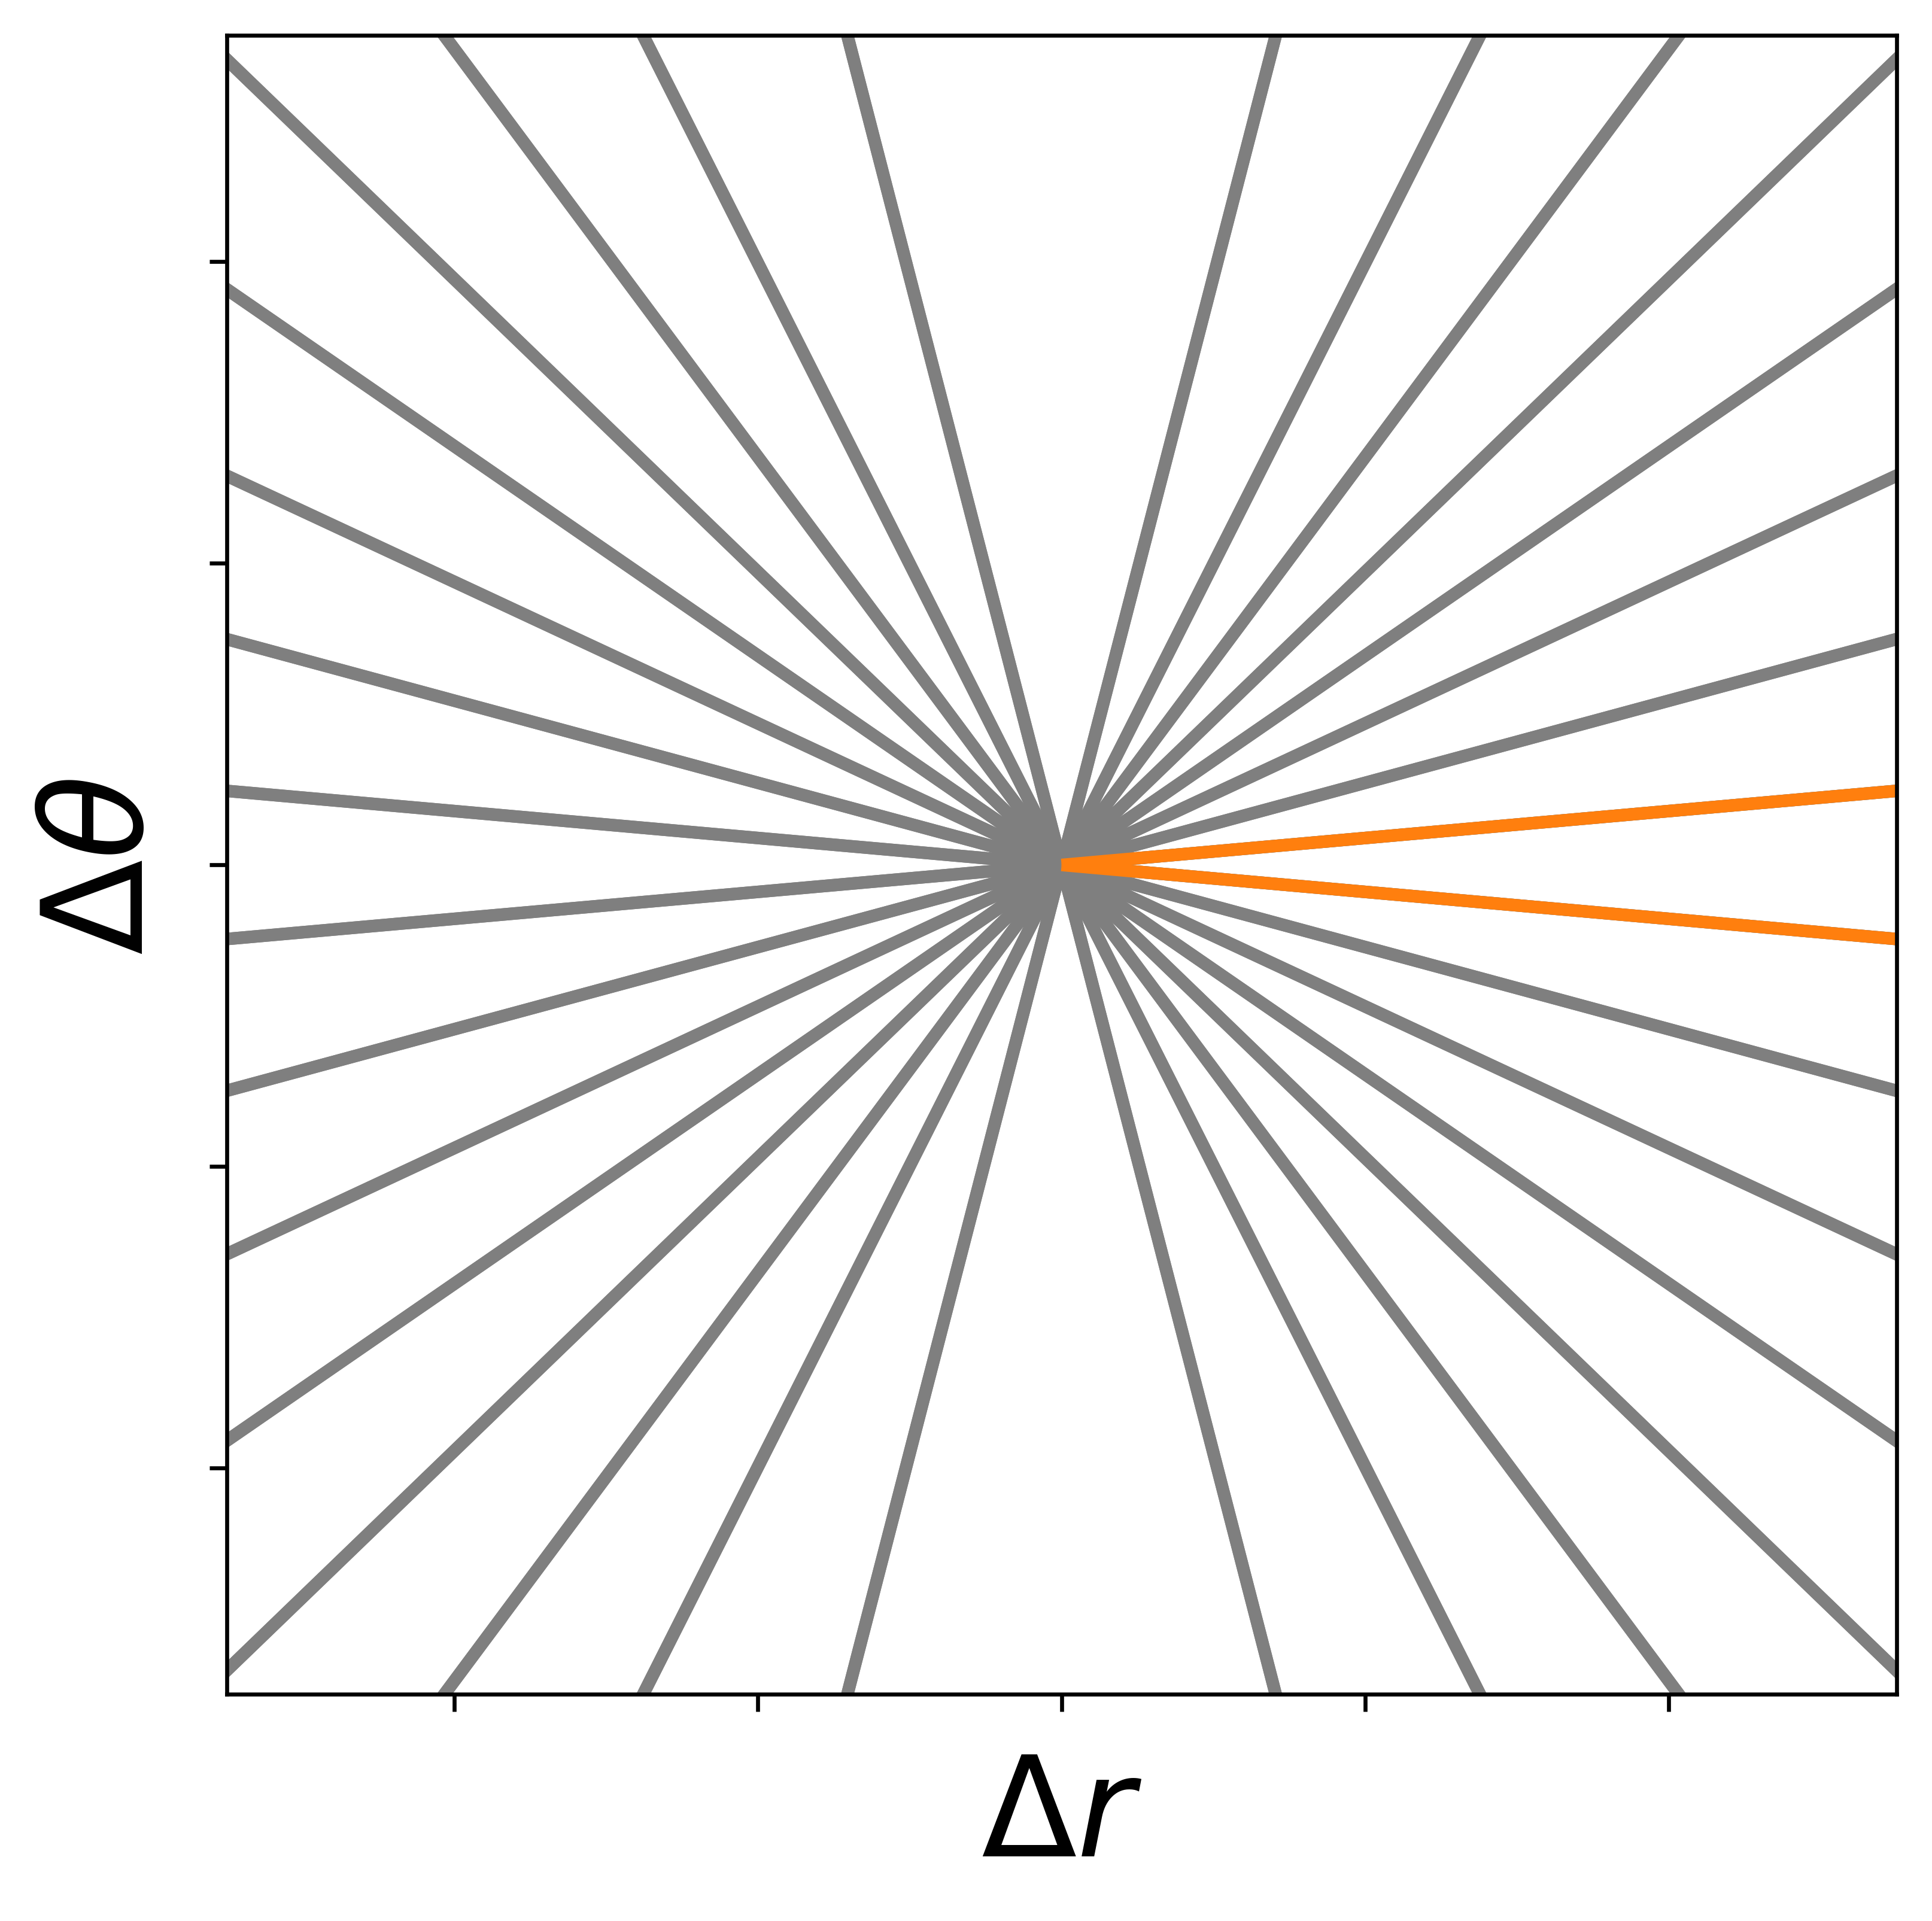

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Make the grid
mu_x, mu_y, mu_z = ns[:, 0], ns[:, 1], ns[:, 2]
x = np.zeros(mu_x.size)
y = np.zeros(mu_y.size)
z = np.zeros(mu_z.size)

upper = 29
lower = 32
ax.quiver(z, x, mu_z, mu_x, scale=1.0, color='tab:grey')
ax.quiver(z[upper], x[upper], mu_z[upper], mu_x[upper],
           scale=1.0, color='tab:orange')
ax.quiver(z[lower], x[lower], mu_z[lower], mu_x[lower],
           scale=1.0, color='tab:orange')
ax.set(xticklabels=[], yticklabels=[])
ax.set_xlabel(r'$\Delta r$', fontsize='28')
ax.set_ylabel(r'$\Delta \theta$', fontsize='28')
plt.savefig(f'figs/radiation.png', bbox_inches='tight', transparent=True,
            pad_inches=0.25)

In [24]:
def AngGrid(nzeta = 3, npsi = 2):
    fracs = np.arange((nzeta - 2), -1, -2)/nzeta
    thetaf = np.arccos(fracs)
    thetaf = np.append(thetaf, (np.pi-np.flip(thetaf)))
    thetaf = np.insert(thetaf, [0, thetaf.size], [0, np.pi])
    cos_thetaf = np.cos(thetaf)
    thetav = np.arccos((cos_thetaf[:-1] + cos_thetaf[1:])/2)
    phif = np.linspace(0, 2*np.pi, 2*npsi+1)
    phiv = (phif[:-1] + phif[1:])/2
    thetamesh, phimesh = np.meshgrid(thetav, phiv)
    mu_x = np.sin(thetamesh)*np.cos(phimesh)
    mu_y = np.sin(thetamesh)*np.sin(phimesh)
    mu_z = np.cos(thetamesh)

    return mu_x, mu_y, mu_z

In [25]:
mu_z = 5.773503e-01
np.arccos(mu_z)

0.9553165803896609

In [26]:
mu_z = .5
np.arccos(mu_z)

1.0471975511965979

In [27]:
AngGrid()[0].size

12

In [28]:
mu_x, mu_y, mu_z = AngGrid()
w = np.copy(mu_x)
w.fill(1/w.size)
w

array([[0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333]])

In [29]:
import numpy as np

def FirstMomSum(mu_x, mu_y, mu_z, w):
    sums = np.empty(3)

    sums[0] = np.sum(mu_x*w) # \Sum mu_x*w_n
    sums[1] = np.sum(mu_y*w) # \Sum mu_y*w_n
    sums[2] = np.sum(mu_z*w) # \Sum mu_z*w_n

    return sums

def SecondMomSum(mu_x, mu_y, mu_z, w):
    sums = np.empty(3)

    for i in range(3):
        sums[i] = np.sum(ns[:, i]**2*w) # \Sum mu_x*w_n

    return sums

In [30]:
AngGrid()[:, 0]

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
nzeta = 3
npsi = 2
mu_x, mu_y, mu_z = AngGrid(nzeta, npsi)
print(mu_x)
print(f' First moment sum: {mu_x, mu_y, mu_z, w}')
# print(f'Second moment sum: {AngGrid(), w}')

[[ 0.52704628  0.70710678  0.52704628]
 [-0.52704628 -0.70710678 -0.52704628]
 [-0.52704628 -0.70710678 -0.52704628]
 [ 0.52704628  0.70710678  0.52704628]]
 First moment sum: (array([[ 0.52704628,  0.70710678,  0.52704628],
       [-0.52704628, -0.70710678, -0.52704628],
       [-0.52704628, -0.70710678, -0.52704628],
       [ 0.52704628,  0.70710678,  0.52704628]]), array([[ 0.52704628,  0.70710678,  0.52704628],
       [ 0.52704628,  0.70710678,  0.52704628],
       [-0.52704628, -0.70710678, -0.52704628],
       [-0.52704628, -0.70710678, -0.52704628]]), array([[ 6.66666667e-01,  6.12323400e-17, -6.66666667e-01],
       [ 6.66666667e-01,  6.12323400e-17, -6.66666667e-01],
       [ 6.66666667e-01,  6.12323400e-17, -6.66666667e-01],
       [ 6.66666667e-01,  6.12323400e-17, -6.66666667e-01]]), array([[0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333]]))


(4, 3)


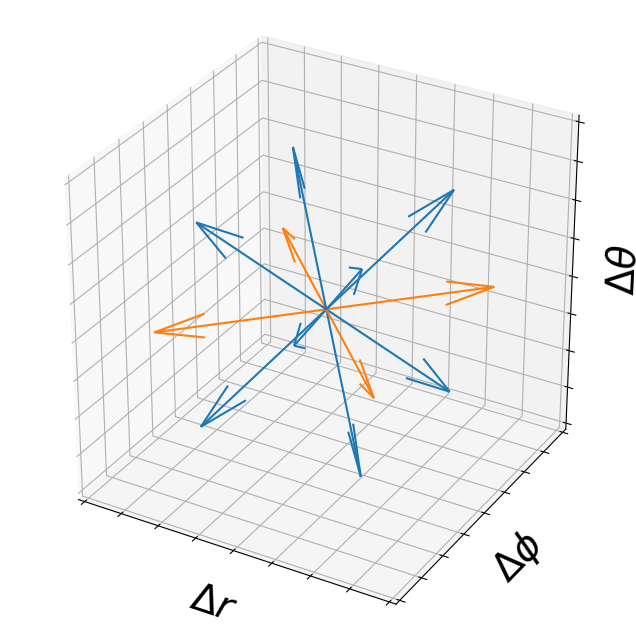

In [46]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

# Make the grid
nzeta = 3
npsi = 2
mu_x, mu_y, mu_z = AngGrid(nzeta, npsi)
print(AngGrid(nzeta, npsi)[0].shape)
x, y, z = np.zeros_like(AngGrid(nzeta, npsi))

ax.quiver(x[:,0], y[:,0], z[:,0], mu_x[:,0], mu_y[:,0], mu_z[:,0], length=1.0)
ax.quiver(x[:,1], y[:,1], z[:,1], mu_x[:,1], mu_y[:,1], mu_z[:,1], length=1.0,
          color='tab:orange')
ax.quiver(x[:,2], y[:,2], z[:,2], mu_x[:,2], mu_y[:,2], mu_z[:,2], length=1.0)
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), aspect='equal',
       xticklabels=[], yticklabels=[], zticklabels=[])
ax.set_aspect('equal')
ax.set_xlabel(r'$\Delta r$', fontsize='28')
ax.set_ylabel(r'$\Delta \phi$', fontsize='28')
ax.set_zlabel(r'$\Delta \theta$', fontsize='28')
plt.savefig(f'figs/custom.png', dpi=800, transparent=True,
            bbox_inches='tight')

In [48]:
mu_x[:,1]

array([ 0.70710678, -0.70710678, -0.70710678,  0.70710678])

(4, 3)


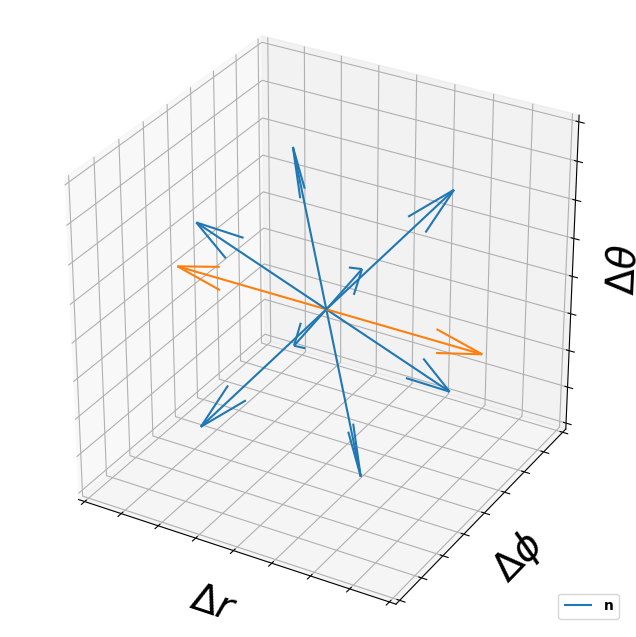

In [59]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

# Make the grid
nzeta = 3
npsi = 2
mu_x, mu_y, mu_z = AngGrid(nzeta, npsi)
print(AngGrid(nzeta, npsi)[0].shape)
x, y, z = np.zeros_like(AngGrid(nzeta, npsi))

ax.quiver(x[:,0], y[:,0], z[:,0], mu_x[:,0], mu_y[:,0], mu_z[:,0],
          label=r'$\mathbf{n}$')
ax.quiver([0, 0], [0, 0], [0, 0], [-1, 1], [0, 0], [0, 0], color='tab:orange')
ax.quiver(x[:,2], y[:,2], z[:,2], mu_x[:,2], mu_y[:,2], mu_z[:,2])
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), aspect='equal',
       xticklabels=[], yticklabels=[], zticklabels=[])
ax.set_aspect('equal')
ax.set_xlabel(r'$\Delta r$', fontsize='28')
ax.set_ylabel(r'$\Delta \phi$', fontsize='28')
ax.set_zlabel(r'$\Delta \theta$', fontsize='28')
ax.legend(loc='lower right')
plt.savefig(f'figs/poster.png', dpi=300, transparent=True, bbox_inches='tight')

(array([[ 0.61237244,  0.70710678,  0.61237244],
       [-0.61237244, -0.70710678, -0.61237244],
       [-0.61237244, -0.70710678, -0.61237244],
       [ 0.61237244,  0.70710678,  0.61237244]]), array([[ 0.61237244,  0.70710678,  0.61237244],
       [ 0.61237244,  0.70710678,  0.61237244],
       [-0.61237244, -0.70710678, -0.61237244],
       [-0.61237244, -0.70710678, -0.61237244]]), array([[ 5.000000e-01,  6.123234e-17, -5.000000e-01],
       [ 5.000000e-01,  6.123234e-17, -5.000000e-01],
       [ 5.000000e-01,  6.123234e-17, -5.000000e-01],
       [ 5.000000e-01,  6.123234e-17, -5.000000e-01]]))


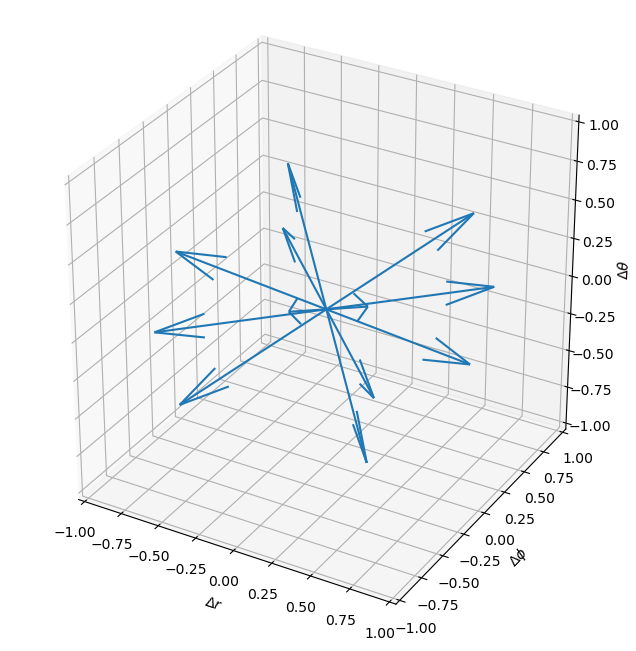

In [ ]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

# Make the grid
nzeta = 2
npsi = 2
mu_x, mu_y, mu_z = AngGrid(nzeta, npsi)
mu_x = mu_x[]
print(AngGrid(nzeta, npsi))
x, y, z = np.zeros_like(AngGrid(nzeta, npsi))

ax.quiver(x, y, z, mu_x, mu_y, mu_z, length=1.0)
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1),
       xlabel=r'$\Delta r$',
       ylabel=r'$\Delta \phi$',
       zlabel=r'$\Delta \theta$')
ax.set_aspect('equal')
plt.savefig(f'figs/custom_tight-only.png', dpi=800, transparent=True,
            bbox_inches='tight')